In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
import seaborn as sns
import time

train = pd.read_csv("../data/avis/train_noYC_lemma_sent_equil.csv", index_col=0)
y_train = train.etoiles
X_train = train.drop("etoiles", axis = 1)
X_train = X_train[['n_avis','sentiment_norm','longueur_texte']]

test = pd.read_csv('../data/avis/test_noYC_lemma_sent_equil.csv')
y_test = test['etoiles']
X_test = test.drop("etoiles", axis =1)
X_test = X_test[['n_avis','sentiment_norm','longueur_texte']]

X_train.head(2)

,n_avis,sentiment_norm,longueur_texte
5529,1.0,0.727087,95
57109,1.0,-0.989352,73


In [2]:
# Fonctions de vectorisation et de reporting
def model_report():
    # measuring time taken to train the model
    t1 = time.time()
    delais = round((t1-t0)/60,2)
    # test score
    try:
        score = round(model.score(X_test, y_test),2)
    except:
        score =  "na"
    print("train score: ", score)

    # predictiong on test set, accomodating to dm matrix in except (test contains X and y)
    try:
        y_pred = model.predict(X_test)
    except:
        y_pred = model.predict(test)
    
    # saving results in the benchmark file
    model_name = type(model).__name__
    report =classification_report(y_test, y_pred, output_dict=True)
    macro_precision =  round(report['macro avg']['precision'],2) 
    macro_recall = round(report['macro avg']['recall'],2)    
    macro_f1 = round(report['macro avg']['f1-score'],2)  
    tempdf = pd.DataFrame({"model":[type(model).__name__],
                       "features": [X_train.columns.values],
                       "score":[score],
                       "precision": [macro_precision],
                       "recall": [macro_recall],
                       "f1":[macro_f1],
                       "time_taken_mns":[delais],
                       "run_date": [time.strftime('%Y-%m-%d', time.localtime())]
                       })
    # reports: classification report and crosstab heatmap 
    print(classification_report(y_test, y_pred))
    # Generate and normalize the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_mat_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Normalized Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # load and append results to the benchmark, save
    bench = pd.read_csv('../reports/model_benchmark.csv', index_col=0)
    bench = pd.concat([bench, tempdf])
    bench.to_csv('../reports/model_benchmark.csv')
def review_vector(df,extra_features):
    from scipy.sparse import csr_matrix, hstack
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # 1000 pour garder l'essentiel, plus?
    vec_text = tfidf_vectorizer.fit_transform(df['text_lemma'])
    print(vec_text[0:5])
    # Ajouter les variables en format dense, comme le texte vectorisé
    df_tf = hstack([vec_text, csr_matrix(df[extra_features])])
    return df_tf

# 0 Modelisation de base n_avis, length

# 1. modelisation n avis, sentiment, longeur txt

train score:  0.32
              precision    recall  f1-score   support

           1       0.35      0.50      0.41       562
           2       0.39      0.15      0.22       562
           3       0.21      0.14      0.17       562
           4       0.18      0.04      0.07       562
           5       0.33      0.76      0.46       562

    accuracy                           0.32      2810
   macro avg       0.29      0.32      0.26      2810
weighted avg       0.29      0.32      0.26      2810



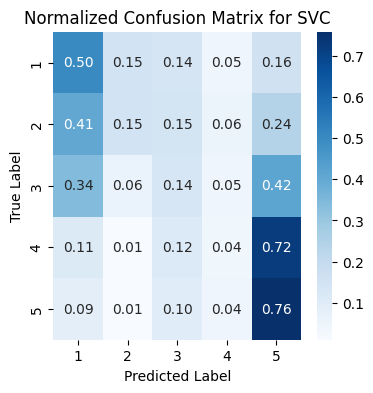

In [3]:
model = svm.SVC()
t0 = time.time()
model.fit(X_train, y_train)
model_report()

# 2. Grid SVM n_avis, sentiment, txt length

In [4]:
# definir des hyper paramètres à tester
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

# tester les différents paramètres
t0= time.time()
model = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
model.fit(X_train, y_train)
print("best parameters", model.best_params_)
model_report()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.316 total time=   4.8s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.302 total time=   4.7s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.298 total time=   4.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.306 total time=   5.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.304 total time=   4.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.364 total time=   5.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.343 total time=   5.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.332 total time=   5.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.358 total time=   5.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.347 total time=   5.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.361 total time=   6.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

NameError: name 'grid' is not defined

# 3. Grid SVM: text TFIDF, n_avis, sent, length

In [ ]:
# Vectorization des avis lémmatisés
X_train = review_vector(train, ["n_avis","longueur_texte"])
X_test = review_vector(test, ["n_avis","longueur_texte"])
# definir des hyper paramètres à tester
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

# tester les différents paramètres
t0= time.time()
model = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
model.fit(X_train, y_train)
# reporting
model_report()

  (0, 855)	0.32081607196866546
  (0, 387)	0.6426909335892877
  (0, 389)	0.33374322311465077
  (0, 666)	0.6104431774324047
  (1, 304)	0.4438164629935987
  (1, 717)	0.41896522746501824
  (1, 889)	0.5268189570945356
  (1, 52)	0.5346602569729778
  (1, 152)	0.2531704591978544
  (2, 956)	0.19989880102477484
  (2, 944)	0.2972539269938943
  (2, 330)	0.5959031414772705
  (2, 491)	0.6418763945901851
  (2, 152)	0.32338013587879977
  (3, 269)	0.24595206014303453
  (3, 661)	0.1552771326651157
  (3, 374)	0.2016611130907169
  (3, 667)	0.25233367368959647
  (3, 657)	0.136508539853891
  (3, 619)	0.20435186291505444
  (3, 148)	0.15905187582853675
  (3, 157)	0.1664489080632572
  (3, 116)	0.1510530693030217
  (3, 976)	0.16034126279567812
  (3, 840)	0.14586143700794157
  (3, 111)	0.1660674829842463
  (3, 431)	0.22752985518704094
  (3, 807)	0.20977731833852464
  (3, 47)	0.24669494743220957
  (3, 994)	0.19188602073534072
  (3, 559)	0.19008844895828986
  (3, 465)	0.1409301831555513
  (3, 357)	0.20537824855759

KeyboardInterrupt: 

# Recap

In [ ]:
bench = pd.read_csv('../reports/model_benchmark.csv', index_col=0)
bench[bench.model == type(model).__name__]

,model,features,score,precision,recall,f1,time_taken_mns,run_date
0,SVC,['n_avis' 'sentiment_norm' 'longueur_texte'],0.32,0.29,0.32,0.26,0.09,2024-02-02
0,SVC,['n_avis' 'sentiment_norm' 'longueur_texte'],0.32,0.29,0.32,0.26,0.08,2024-02-02
0,SVC,['n_avis' 'sentiment_norm' 'longueur_texte'],0.32,0.29,0.32,0.26,0.08,2024-02-02
0,SVC,['n_avis' 'sentiment_norm' 'longueur_texte'],0.32,0.29,0.32,0.26,0.08,2024-02-02
